In [2]:
cd ~/microbiome_rnn/

/Volumes/export/isn/mwiest/microbiome_rnn


In [37]:
from __future__ import print_function
import os
import torch
import numpy as np
import pandas as pd
import sys
from otu_handler import OTUHandler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from scipy.stats.mstats import zscore
import matplotlib.gridspec as gridspec
%matplotlib inline

In [4]:
def complete_and_multiindex_df(df):
    default_tax = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    s = list(df.index.values)
    lt = [list(ls.split(';')) for ls in s]
    for l in lt:
        if len(l) < len(default_tax):
            l += default_tax[-(len(default_tax)-len(l)):]

    ltn = pd.DataFrame(np.array(lt))
    ltn.index = df.index
    ltn.columns = default_tax
    combined = pd.concat((df, ltn), axis=1)
    combined.set_index(default_tax, inplace=True)
    return combined


In [5]:
input_dir = 'all_studies_reduced_62/'
files = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
oh = OTUHandler(files)

In [6]:
# Get color labels so that we can color the points based on taxonomy.
tax_levels = 3
split_char = ';'
join_char = '\n'
labs = [join_char.join(c.split(split_char)[1:tax_levels]) for c in oh.samples[0].index.values]
full_labs = [join_char.join(c.split(split_char)) for c in oh.samples[0].index.values]
for i, l in enumerate(labs):
    if l == '':
        labs[i] = '?'
unique_labs = list(set(labs))
unique_ints = list(range(len(unique_labs)))
unique_int_lookup = dict(zip(unique_labs, unique_ints))
labs_to_ints = [unique_int_lookup[l] for l in labs]
print('There are {} distinct groups'.format(len(unique_labs)))

There are 13 distinct groups


In [7]:
# Now define the colormap
num_colors = len(list(set(labs)))
cmap = plt.cm.get_cmap('tab20', num_colors)
colors = cmap(np.linspace(0, 1, num_colors))
color_lookup = dict(zip(unique_labs, colors))
colors_to_plot = [color_lookup[l] for l in labs]

# Perform PCA Across Time

Text(0.5,1.005,'PCA Performed Across Time For Samples')

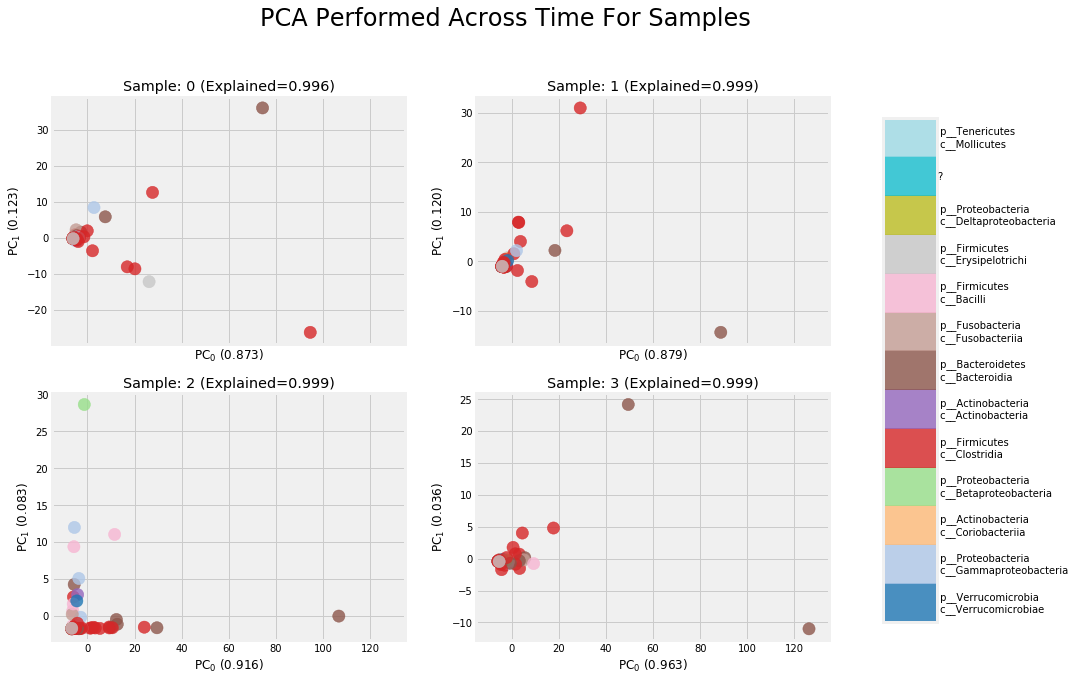

In [12]:
num_samples = len(oh.samples)
fig, ax = plt.subplots(int(num_samples / 2), 2, figsize=(15, 10), sharex=True, sharey=False)
axl = ax.flatten()
for i, s in enumerate(oh.samples):
    zs = zscore(s.values, axis=0)
    pca = PCA(n_components=2)
    pca.fit(zs)
    t = pca.transform(zs)
    x_vals = t[:, 0]
    y_vals = t[:, 1]
    sc = axl[i].scatter(x_vals, y_vals, c=labs_to_ints, cmap=cmap, s=150, alpha=0.8)
    axl[i].set_title('Sample: {} (Explained={})'.format(i, 
                                                               str(sum(pca.explained_variance_ratio_[:2]))[:5]
                                                              ))
    axl[i].set_xlabel('PC$_0$ ({})'.format(str(pca.explained_variance_ratio_[0])[:5]))
    axl[i].set_ylabel('PC$_1$ ({})'.format(str(pca.explained_variance_ratio_[1])[:5]))
    
    # Uncommenting this will annotate each point so that you can see which it is to remove it later potentially.
#     for j, txt in enumerate(full_labs):
#         axl[i].annotate(txt, (x_vals[j], y_vals[j]), fontsize=6)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)
cb = plt.colorbar(sc, cax=cbar_ax)
cb.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(unique_labs):
    cb.ax.text(1, (2 * j + 1) / 26.0, lab, ha='left', va='center', fontsize=10)
plt.suptitle('PCA Performed Across Time For Samples', fontsize=24, y=1.005)

Text(0.5,1.005,'PCA Performed Across Samples')

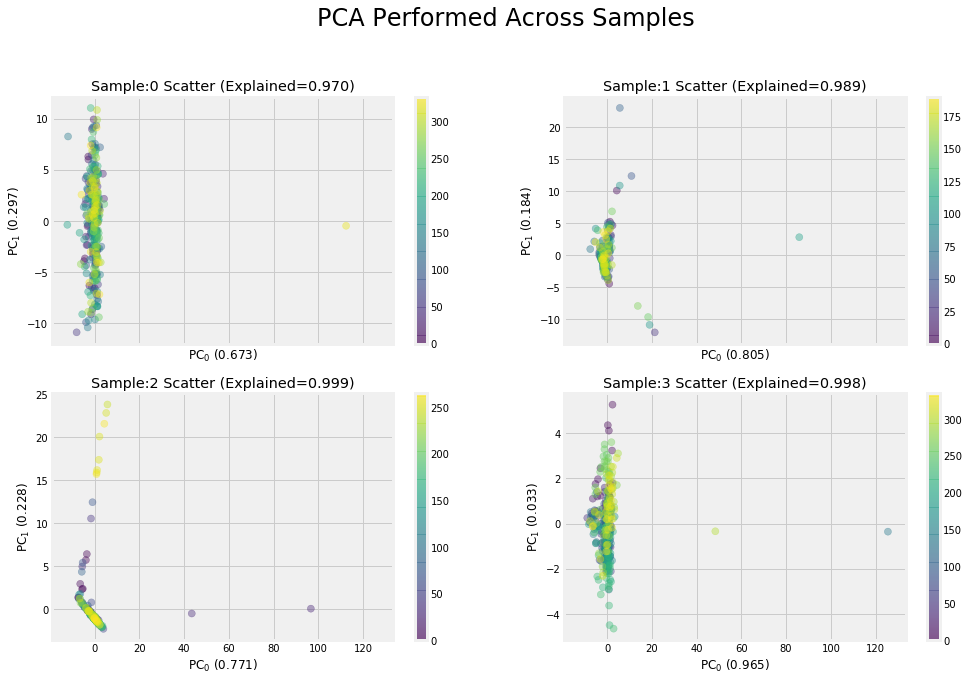

In [13]:
fig, ax = plt.subplots(int(num_samples / 2), 2, figsize=(15, 10), sharex=True, sharey=False)
axl = ax.flatten()
for i, s in enumerate(oh.samples):
    zs = zscore(s.values, axis=1).T
    pca = PCA(n_components=2)
    pca.fit(zs)
    t = pca.transform(zs)
    sc = axl[i].scatter(t[:, 0], t[:, 1], c=range(t.shape[0]), cmap='viridis', s=50, alpha=0.4)
    axl[i].set_title('Sample:{} Scatter (Explained={})'.format(i, 
                                                               str(sum(pca.explained_variance_ratio_[:2]))[:5]
                                                              ))
    axl[i].set_xlabel('PC$_0$ ({})'.format(str(pca.explained_variance_ratio_[0])[:5]))
    axl[i].set_ylabel('PC$_1$ ({})'.format(str(pca.explained_variance_ratio_[1])[:5]))
    cb = plt.colorbar(sc, ax=axl[i])
plt.suptitle('PCA Performed Across Samples', fontsize=24, y=1.005)

# Look at prevalence of different strains
By sample we are going to plot the count of each strain, their averages, and sum.

In [15]:
# How many taxonomy levels to include in the plots. 
# Higher numbers results in a a larger number of strains, ie less grouping
levels = 3
# Reindex the dataframes
multi_samples = [complete_and_multiindex_df(s) for s in oh.samples]

In [74]:

# Get various pieces of data about the taxonomy.
grouped = [ms.groupby(level=list(range(1, levels))) for ms in multi_samples]
# Taxonomy names
labels = ['\n'.join(c) for c in grouped[0].count().index]

counts = [g.count().values[:, 0] for g in grouped]
means = [g.mean().values[:, 0] for g in grouped]
sums = [g.sum().values[:, 0] for g in grouped]



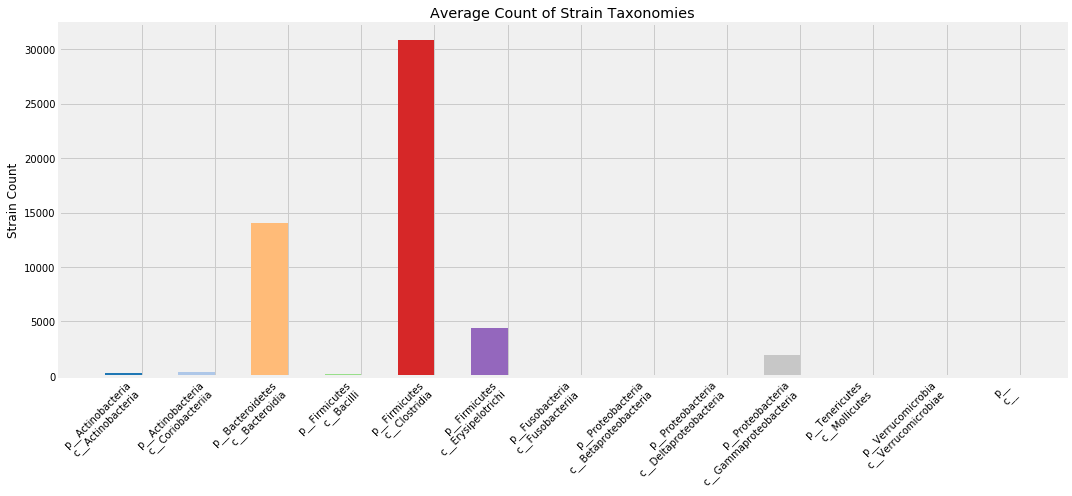

In [77]:
fig, ax = plt.subplots(figsize=(15, 7))
bar_width = 0.50
rects1 = ax.bar(np.arange(len(labels)), sums[0], bar_width, color=colors)
ax.set_xticks(np.arange(len(labels)) + bar_width / 2)
ax.set_xticklabels(labels,
                   ha='right',
                   fontsize=10, rotation=45)
plt.ylabel('Strain Count')
plt.title('Average Count of Strain Taxonomies')
plt.tight_layout()
plt.show()